## Classical MLP

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
# Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='mnist_data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.79MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.57MB/s]


In [4]:
# Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)
        return y_pred, h_2

In [5]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [6]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(28*28, 10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [7]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

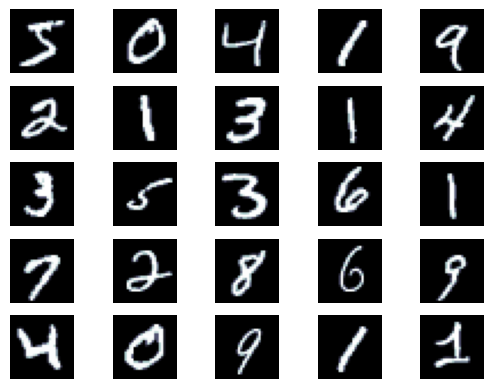

In [8]:
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [9]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [10]:
# Train the model
def train(model, train_loader, test_loader, optimizer, criterion, device, epochs):
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output, _ = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        # Calculate average training loss for the epoch
        train_loss = train_loss / len(train_loader.dataset)

        # Evaluate on test data
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        # Print epoch results
        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f} - "
              f"Test Loss: {test_loss:.4f} - "
              f"Test Accuracy: {test_acc:.4f}")

In [11]:
# Evaluate model accuracy on clean images
def evaluate(model, loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images.view(images.shape[0], -1))
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy

In [12]:
epochs = 5
train(model, train_loader, test_loader, optimizer, criterion, device, epochs)

Training Progress:  20%|██        | 1/5 [00:10<00:42, 10.59s/it]

Epoch [1/5] - Train Loss: 0.3545 - Test Loss: 0.1638 - Test Accuracy: 0.9511


Training Progress:  40%|████      | 2/5 [00:19<00:28,  9.46s/it]

Epoch [2/5] - Train Loss: 0.1362 - Test Loss: 0.1052 - Test Accuracy: 0.9689


Training Progress:  60%|██████    | 3/5 [00:28<00:18,  9.23s/it]

Epoch [3/5] - Train Loss: 0.0920 - Test Loss: 0.0911 - Test Accuracy: 0.9707


Training Progress:  80%|████████  | 4/5 [00:37<00:09,  9.18s/it]

Epoch [4/5] - Train Loss: 0.0670 - Test Loss: 0.0874 - Test Accuracy: 0.9712


Training Progress: 100%|██████████| 5/5 [00:46<00:00,  9.22s/it]

Epoch [5/5] - Train Loss: 0.0511 - Test Loss: 0.0816 - Test Accuracy: 0.9746


In [13]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'mnist_mlp_model.pth')

In [14]:
model.load_state_dict(torch.load('mnist_mlp_model.pth'))
model.eval()  # Set the model to evaluation mode

# Evaluate on the test dataset
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9746


Data Poisoning Attack

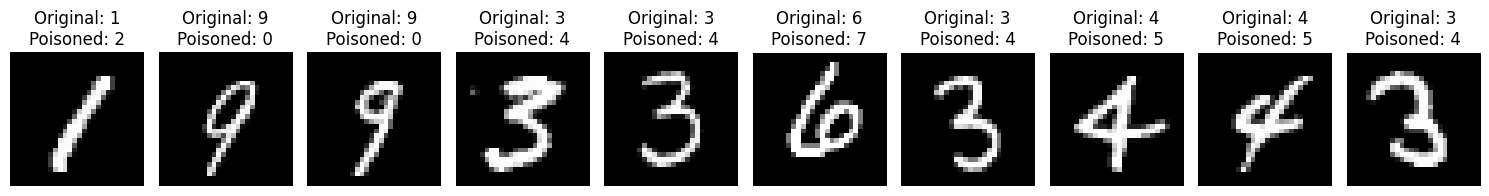

In [15]:

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import random

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(
    root='mnist_data',
    train=True,
    transform=transform,
    download=False  # ❗Don't re-download it
)

test_dataset = datasets.MNIST(
    root='mnist_data',
    train=False,
    transform=transform,
    download=False
)


# Load MNIST normally
transform = transforms.ToTensor()
#train_dataset = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
#test_dataset = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)

# Flip labels for a % of training data
def poison_data(dataset, poison_fraction=0.7):
    poisoned = []
    for img, label in dataset:
        if random.random() < poison_fraction:
            poisoned.append((img, (label + 1) % 10))  # Flip label
        else:
            poisoned.append((img, label))
    return poisoned

poisoned_data = poison_data(train_dataset, poison_fraction=0.05)

# Custom Dataset wrapper
class PoisonedMNIST(Dataset):
    def __init__(self, data):
        self.data = data
    def __getitem__(self, idx):
        return self.data[idx]
    def __len__(self):
        return len(self.data)

# DataLoaders
train_loader = DataLoader(PoisonedMNIST(poisoned_data), batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Visualize poisoned samples
def show_only_poisoned(poisoned, original, n=10):
    flipped = [(p[0], p[1], o[1]) for p, o in zip(poisoned, original) if p[1] != o[1]]
    fig, axes = plt.subplots(1, n, figsize=(15, 2))
    for i in range(n):
        img, plabel, olabel = flipped[i]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f"Original: {olabel}\nPoisoned: {plabel}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


# Load original labels
original_train = list(datasets.MNIST(root='mnist_data', train=True, transform=transform, download=False))
show_only_poisoned(poisoned_data, original_train)

Defense by label smoothing

In [16]:
# Count how many labels were flipped
original_train = list(datasets.MNIST(root='mnist_data', train=True, transform=transform, download=False))
poisoned_count = sum(
    1 for (p, o) in zip(poisoned_data, original_train) if p[1] != o[1]
)
print(f"Poisoned labels: {poisoned_count} / {len(poisoned_data)}")


Poisoned labels: 3051 / 60000


In [17]:
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)


In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
def train(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images.view(images.size(0), -1))  # Flatten
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

In [22]:
train(model, train_loader, criterion, optimizer, epochs=5)

Epoch 1, Loss: 469.4485
Epoch 2, Loss: 379.1988
Epoch 3, Loss: 359.2933
Epoch 4, Loss: 348.4171
Epoch 5, Loss: 340.9573


In [23]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images.view(images.size(0), -1))
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

evaluate(model, test_loader)

Test Accuracy: 97.46%


In [24]:
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images.view(images.size(0), -1))
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

preds, labels = get_predictions(model, test_loader)

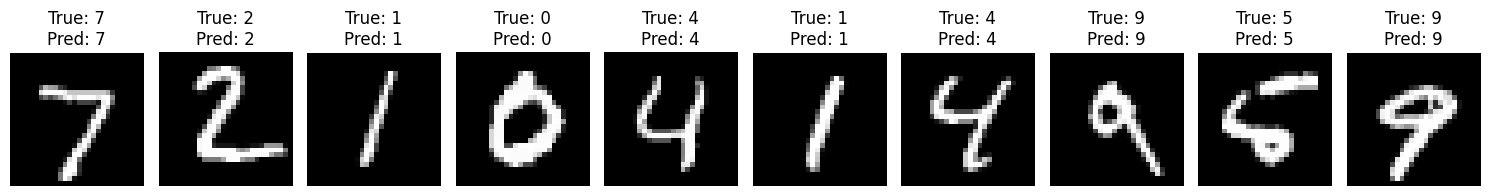

In [25]:
def visualize_predictions(loader, preds, labels, num_images=10):
    images, _ = next(iter(loader))  # get a batch
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img = images[i].squeeze().numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"True: {labels[i]}\nPred: {preds[i]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(test_loader, preds, labels)